In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import torch

from hysteresis.linear_bayesian import BayesianLinearizedHysteresis
from hysteresis.linearized import LinearizedHysteresis
from hysteresis.training import train_bayes, map_bayes

calculated 22 states


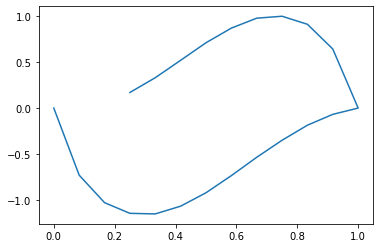

In [15]:
fname = '../../facet_ii_data/quadrupoles/quad_m1-34.ru1'
data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)
data[:, 1] = data[:, 1]
data[:, 3] = data[:, 3] * np.where(data[:,7] < 0, -1, 1)

# get real h, m
h_full = torch.tensor(data[:,1]).double()
m_full = torch.tensor(data[:,3]).double()

h = torch.tensor(data[:,1]).double()[:-3]
m = torch.tensor(data[:,3]).double()[:-3]

H = LinearizedHysteresis(h, m, mesh_scale=0.5, trainable=False)

hl = H.transformer.transform_h(h)
ml = H.transformer.transform_m(m, h)

plt.plot(hl, ml)


In [16]:
from hysteresis.bayesian import positional_covariance

def cov(model):
    return positional_covariance(model, 1.0)

# Do SVI estimate w/o correlations
B = BayesianLinearizedHysteresis(H)
guide, loss = train_bayes(h, ml, B, 10000, initial_lr=0.001)

[iteration 0001] loss: 425261.5191
[iteration 0101] loss: 257440.5001
[iteration 0201] loss: 293922.5862
[iteration 0301] loss: 277095.9969
[iteration 0401] loss: 362944.0410
[iteration 0501] loss: 329430.2380
[iteration 0601] loss: 373717.2315
[iteration 0701] loss: 202288.8700
[iteration 0801] loss: 193872.5550
[iteration 0901] loss: 52563.9142
[iteration 1001] loss: 23462.1191
[iteration 1101] loss: 16920.1608
[iteration 1201] loss: 31700.3967
[iteration 1301] loss: 8493.8237
[iteration 1401] loss: 12644.8628
[iteration 1501] loss: 22259.0965
[iteration 1601] loss: 40310.4647
[iteration 1701] loss: 19211.1455
[iteration 1801] loss: 28758.0203
[iteration 1901] loss: 42672.2620
[iteration 2001] loss: 14947.5415
[iteration 2101] loss: 20738.0371
[iteration 2201] loss: 38079.4645
[iteration 2301] loss: 51804.0109
[iteration 2401] loss: 8471.6748
[iteration 2501] loss: 3102.0341
[iteration 2601] loss: 40149.0259
[iteration 2701] loss: 27826.4569
[iteration 2801] loss: 30529.9456
[iterati

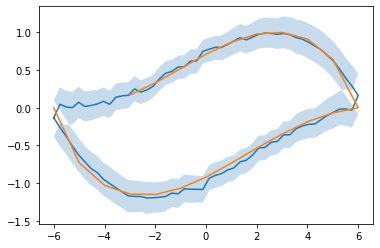

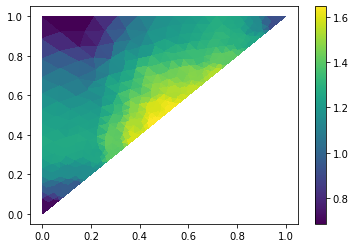

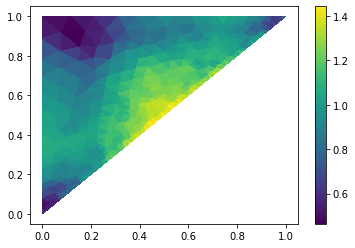

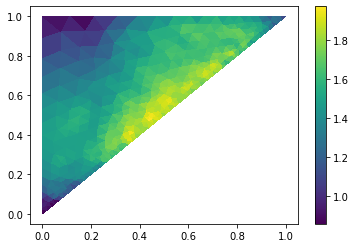

In [21]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density

t = torch.linspace(0, 1, 50)
h_test = torch.cat((t, t.flipud()))
h_test = H.unnormalize_h(h_test)
pred_summary, samples = predict(h_test, B, guide)
mean = pred_summary['obs']['mean']
upper = pred_summary['obs']['95%']
lower = pred_summary['obs']['5%']

plt.plot(h_test, mean)
plt.fill_between(h_test, lower, upper, alpha=0.25)
plt.plot(h, ml)

dens = torch.nn.Softplus()(pred_summary['density']['mean'].detach().flatten())
fig,ax = plot_hysteresis_density(H, dens)

dens = torch.nn.Softplus()(pred_summary['density']['5%'].detach().flatten())
fig,ax = plot_hysteresis_density(H, dens)

dens = torch.nn.Softplus()(pred_summary['density']['95%'].detach().flatten())
fig,ax = plot_hysteresis_density(H, dens)



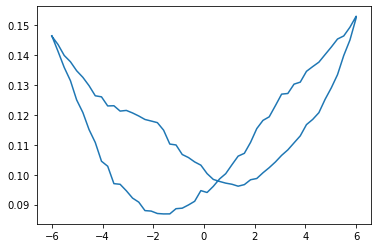

In [18]:
plt.plot(h_test, pred_summary['obs']['std'])


In [19]:
import pyro
#for name, item in pyro.get_param_store().items():
#    print(f'{name}:{item}')